In [79]:

%reload_ext autoreload
%autoreload 2
import tensorflow as tf

from func import *
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)




In [80]:
filename = 'all_data_anonymized.csv'
date_col = 'todate'
start_date = '1980-01-01'
seperator = ';'
fill = 0
lim = 5
df_read = load_and_preprocess_data(filename, date_col, start_date, seperator, fill, lim)


d:\master3\Master-thesis\Files\func.py:29: DtypeWarning: Columns (15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(filename, sep=seperator)


In [81]:
windows = [5, 10, 20, 40, 60, 100, 180, 240, 360, 480]
window_m = [10, 30, 60, 100, 180]
assets = df_read.columns
df_feat = add_features(df_read, window_m)

In [82]:
target_days = 10
cross = False
return_column_shift = 'avgreturn'
volatility_column_shift = 'volatility'
df = add_y_col(df_feat, df_read, date_col, target_days, return_column_shift, volatility_column_shift, cross)

In [83]:
X_train, X_eval, X_test, y_train, y_eval, y_test, X_train_eval, y_train_eval = prepare_training_dataset(df, date_col, shuffle=False, train_split=0.25, eval_split=0.25)

In [84]:
# load all models
%reload_ext autoreload
%autoreload 2
"""NN_model = load_model('NN_model.h5')
ridge_best = pickle.load(open('ridge_model.pickle', 'rb'))
lgb_best = pickle.load(open('lgb_model.pickle', 'rb'))
"""
param_grid_NN = {
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [50],  
    'batch_size': [32, 64]
}
#param_grid_NN =  {'batch_size': [64], 'epochs': [50], 'optimizer': ['rmsprop']}

#NN_model, best_params, X_test_scaled = optimize_and_train_NN(X_train, y_train, X_eval, y_eval, X_test, param_grid_NN, cross)



param_grid_alpha = {'alpha': [0.1, 1.0, 10.0]}
#param_grid_alpha = {'alpha': [1.0]}
ridge_best, grid_search = optimize_and_train_ridge(X_train, y_train, X_train_eval, y_train_eval, param_grid_alpha, cross,random_seed=42)


param_grid_lgb = {
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 63, 127, 255]
}


#lgb_best, best_params = optimize_and_train_lgb(X_train, y_train, X_eval, y_eval, param_grid_lgb, cross)


Best parameters: {'alpha': 1.0}
Best accuracy on evaluation set: 0.5396410186952494


In [85]:
# Store predictions in a dictionary
"""predictions = {
    "Ridge Classifier": ridge_best.predict(X_test),
    "LightGBM Classifier": lgb_best.predict(X_test),
    "Neural Network": NN_model.predict(X_test_scaled)
}   

# Iterate through the dictionary and evaluate each model
for model_name, y_pred in predictions.items():
    print(model_name + ":")
    if model_name == "Neural Network":
        y_pred = (y_pred > 0.5).astype(int)
    evaluate_model_performance(y_test, y_pred)
    print("\n")"""


'predictions = {\n    "Ridge Classifier": ridge_best.predict(X_test),\n    "LightGBM Classifier": lgb_best.predict(X_test),\n    "Neural Network": NN_model.predict(X_test_scaled)\n}   \n\n# Iterate through the dictionary and evaluate each model\nfor model_name, y_pred in predictions.items():\n    print(model_name + ":")\n    if model_name == "Neural Network":\n        y_pred = (y_pred > 0.5).astype(int)\n    evaluate_model_performance(y_test, y_pred)\n    print("\n")'

In [96]:
# keep same index from X_test in df as new df

df_2 = df.loc[X_test.index]
# Use the dates in df_2 to filter rows in df_read
df_2_read = df_read.loc[df_2[date_col].unique()]

# fill missing values with 0
df_2_read.fillna(0, inplace=True)


In [97]:
results_best = {}
results_worst = {}
models = {
#    'lgb': lgb_best,
    'ridge': ridge_best,
#    'NN': NN_model,
    'benchmark': None
}

df_2_neutral = df_2_read.copy()

for col in df_2_neutral.columns:
    df_2_neutral[col] = 0
    



model_dfs = {
    'lgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy(),
    'benchmark': df_2_neutral.copy()
}


In [98]:
%reload_ext autoreload
%autoreload 2

signals_dfs = {
    'lgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy(),
    'benchmark': df_2_neutral.copy()
}

portfolio_dfs = {
    'lgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy(),
    'benchmark': df_2_neutral.copy()
}

for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name, df_read, date_col, cross, top_percentile=70, bottom_percentile=30) 
    assets_df = pd.concat([best_assets, worst_assets])
    assets_df['update_value'] = 0
    assets_df.loc[assets_df[name] > assets_df['top_threshold'], 'update_value'] = 1
    assets_df.loc[assets_df[name] < assets_df['bottom_threshold'], 'update_value'] = -1

    pivot_df = assets_df.pivot_table(index='todate', columns='asset', values='update_value', fill_value=0)
    signals_dfs[name].update(pivot_df)

    portfolio_dfs[name] = update_df_with_asset_performance(signals_dfs[name].shift(2).dropna(how='all'), portfolio_dfs[name], target_days, df_read)


In [99]:
#portfolio_dfs['ridge'].head(25)

signals_dfs['ridge'].head(25)

,EQ_0,EQ_1,EQ_2,EQ_3,EQ_4,EQ_5,EQ_6,EQ_7,EQ_8,EQ_9,EQ_10,EQ_11,EQ_12,EQ_13,EQ_14,EQ_15,EQ_16,EQS_0,EQS_1,EQS_2,EQS_3,EQS_4,EQS_5,EQS_6,EQS_7,EQS_8,EQS_9,EQS_10,FI_0,FI_1,FI_2,FI_3,FI_4,FI_5,FI_6,FI_7,FI_8,FI_9,FI_10,FI_11,FI_12,FI_13,FI_14,FXD_0,FXD_1,FXD_2,FXD_3,FXD_4,FXD_5,FXD_6,FXD_7,FXD_8,FXD_9,FXE_0,FXE_1,FXE_2,FXE_3,FXE_4,MACRO_8,MACRO_0,MACRO_1,MACRO_2,MACRO_3,MACRO_4,MACRO_5,MACRO_6,MACRO_7
todate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0
2011-01-06,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0
2011-01-07,0,0,-1,1,1,0,0,0,0,-1,0,0,-1,-1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-10,-1,0,-1,1,0,0,0,-1,-1,-1,-1,0,-1,-1,0,0,-1,0,0,0,0,0,0,0,0,0,0,-1,0,-1,0,0,0,-1,0,0,1,0,0,0,0,0,0,0,0,1,0,-1,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0
2011-01-11,0,1,0,1,1,1,0,0,0,-1,0,0,0,-1,1,0,-1,0,1,0,0,0,0,0,1,0,0,-1,0,0,1,1,0,0,0,1,1,1,1,1,1,1,1,-1,1,1,0,0,0,0,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-12,0,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,-1,1,1,0,0,0,0,0,1,0,0,-1,0,0,1,0,1,0,0,0,0,0,1,1,1,0,1,-1,1,1,0,0,0,0,0,1,-1,0,1,0,1,0,0,0,0,0,0,0,0,0,0
2011-01-13,0,0,0,1,0,1,0,0,0,0,1,1,1,-1,1,0,-1,0,0,0,0,0,0,0,1,0,0,-1,-1,-1,0,0,0,-1,-1,-1,-1,0,0,0,1,0,0,-1,1,0,-1,0,-1,0,0,0,-1,0,1,-1,1,-1,0,0,0,0,0,0,0,0,0
2011-01-14,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,-1,1,0,0,0,0,-1,0,1,0,0,-1,-1,-1,0,-1,1,-1,-1,-1,-1,-1,0,0,0,-1,0,-1,1,0,-1,0,-1,0,-1,0,-1,0,1,-1,0,-1,0,0,0,0,0,0,0,0,0
2011-01-17,0,0,0,1,0,0,0,-1,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,-1,0,0,-1,0,-1,-1,-1,0,-1,0,-1,-1,-1,-1,0,0,0,0,0,0,-1,1,0,-1,0,-1,0,-1,0,-1,-1,0,-1,0,-1,0,0,0,0,0,0,0,0,0


In [100]:
lgb_weights = portfolio_dfs['lgb']
ridge_weights = portfolio_dfs['ridge']
NN_weights = portfolio_dfs['NN']
benchmark_weights = portfolio_dfs['benchmark']




lgb_returns = lgb_weights*df_2_read
ridge_returns = ridge_weights*df_2_read
NN_returns = NN_weights*df_2_read
benchmark_returns = benchmark_weights*df_2_read



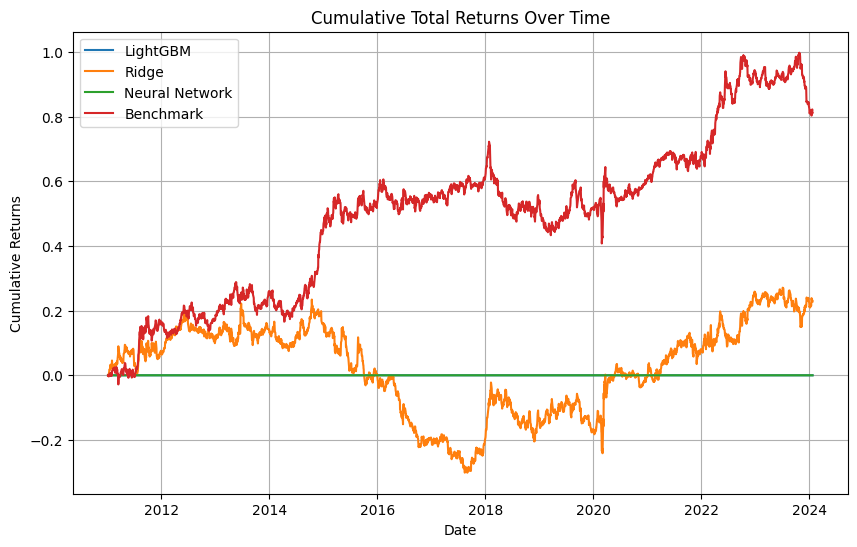

In [101]:
import matplotlib.pyplot as plt

# Sum the returns across all assets for each day to get the daily total returns for each model
lgb_total_returns = lgb_returns.sum(axis=1)
ridge_total_returns = ridge_returns.sum(axis=1)
NN_total_returns = NN_returns.sum(axis=1)
benchmark_total_returns = benchmark_returns.sum(axis=1)

lgb_cumulative_total_returns = lgb_total_returns.cumsum()
ridge_cumulative_total_returns = ridge_total_returns.cumsum()
NN_cumulative_total_returns = NN_total_returns.cumsum()
benchmark_cumulative_total_returns = benchmark_total_returns.cumsum()

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(lgb_cumulative_total_returns, label='LightGBM')
plt.plot(ridge_cumulative_total_returns, label='Ridge')
plt.plot(NN_cumulative_total_returns, label='Neural Network')
plt.plot(benchmark_cumulative_total_returns, label='Benchmark')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [102]:
%reload_ext autoreload
%autoreload 2
#ridge_metrics = financial_metrics(ridge_total_returns, ridge_weights)
#lgb_metrics = financial_metrics(lgb_total_returns, lgb_weights)
#NN_metrics = financial_metrics(NN_total_returns,NN_weights )
benchmark_metrics = financial_metrics(benchmark_total_returns, benchmark_weights)
metrics = {
#    "Ridge": ridge_metrics,
#    "LightGBM": lgb_metrics,
#    "Neural Network": NN_metrics,
    "Benchmark": benchmark_metrics
}

metrics_df = pd.DataFrame(metrics).T  


In [103]:
metrics_df

,Average Yearly Return,Average Yearly Standard Deviation,Calmar Ratio,Kurtosis,Max Drawdown,Skewness,Yearly Sharpe Ratio,Yearly Trades,Yearly Transaction Costs,Yearly Turnover,Yearly Volatility
Benchmark,0.060888,0.116361,0.225607,6.673095,-0.269885,0.257438,0.523266,1129.071429,0.004909,49.085302,0.116361


In [104]:
ridge_turnover = ridge_weights.diff().abs().sum(axis=1)
lgb_turnover = lgb_weights.diff().abs().sum(axis=1)
NN_turnover = NN_weights.diff().abs().sum(axis=1)
bench_turnover = benchmark_weights.diff().abs().sum(axis=1)


ridge_trans_cost = ridge_turnover * 0.01 *0.01
lgb_trans_cost = lgb_turnover * 0.01 * 0.01
NN_trans_cost = NN_turnover * 0.01 * 0.01
bench_trans_cost = bench_turnover * 0.01 * 0.01

ridge_adjusted_returns = ridge_total_returns - ridge_trans_cost
lgb_adjusted_returns = lgb_total_returns - lgb_trans_cost
NN_adjusted_returns = NN_total_returns - lgb_trans_cost
bench_adjusted_returns = benchmark_total_returns - bench_trans_cost

ridge_cumulative_total_returns_post_cost = ridge_adjusted_returns.cumsum()
lgb_cumulative_total_returns_post_cost = lgb_adjusted_returns.cumsum()
NN_cumulative_total_returns_post_cost = NN_adjusted_returns.cumsum()
bench_cumulative_total_returns_post_cost = bench_adjusted_returns.cumsum()



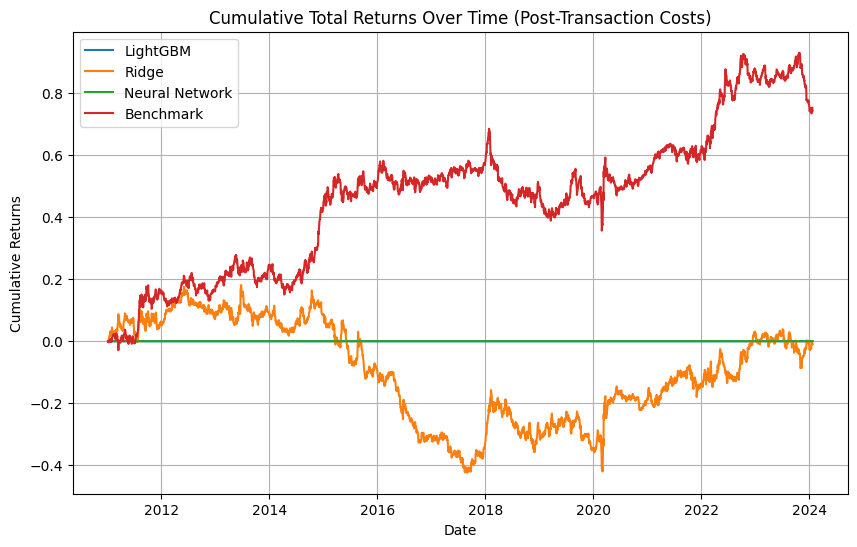

In [105]:



# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(lgb_cumulative_total_returns_post_cost, label='LightGBM')
plt.plot(ridge_cumulative_total_returns_post_cost, label='Ridge')
plt.plot(NN_cumulative_total_returns_post_cost, label='Neural Network')
plt.plot(bench_cumulative_total_returns_post_cost, label='Benchmark')
plt.title('Cumulative Total Returns Over Time (Post-Transaction Costs)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

